## Assignment 3
### -- Pattern Recognition
### -- João Pedro Moreto Lourenção

##### ---> Enunciado
Considere a base de detecção de queda usando acelerômetro proposta em: http://fenix.univ.rzeszow.pl/~mkepski/ds/uf.html e disponível (com conjunto de treino e teste separados) neste link(https://drive.google.com/file/d/1_onAYR7VG8jv2pz3uNDHuSCwJEE1we46/view?usp=sharing).

Para esta base (modificada em relação à original):

a) Identifique a melhor forma de extrair características dos sinais do acelerômetro e monte uma base de treinamento e teste a partir da base do item contendo apenas as features para cada exemplo de queda e não-queda (ADL). Sugestão: valor máximo, médio, desvio padrão, etc. Os vídeos disponíveis no site e uma visualização dos sinais (plot) podem ajudar.

b) Aplique os classificadores vistos em aula até o momento, verificando o resultado de classificação na base de treinamento e teste.


OBS: Raw accelerometric data contains time in milliseconds since sequence start and accelerometer data: 
𝑆𝑉𝑡𝑜𝑡𝑎𝑙, 𝐴𝑥, 𝐴𝑧, 𝐴𝑦. All accelerometer data are in gravity units (g). Total sum vector is calculated as follows

---

No trecho de código abaixo, os arquivos são lidos e as colunas que contém os dados do acelerômetro são considerados para calcular a norma. Essa norma é utilizada para calcular as características escolhidas: média, valor máximo, desvio padrão, amplitude e energia. Após isso, são criados dataframes para armazenar essas informações relevantes, que serão utilizadas pelos métodos de predição.

In [11]:
import pandas as pd
import numpy as np
import os

def extract_features(file_path):
    
    data = pd.read_csv(file_path, header=None)
    
    Ax = data.iloc[:, 1]
    Az = data.iloc[:, 2]
    Ay = data.iloc[:, 3]
    
    norma = np.sqrt(Ax**2 + Ay**2 + Az**2)
    
    mean_val = np.mean(norma)
    max_val = np.max(norma)
    std_val = np.std(norma)
    amplitude = max_val - np.min(norma)
    energy = np.sum(norma**2)
    
    feature_vector = np.array([mean_val, max_val, std_val, amplitude, energy])
    
    return feature_vector

fall_train_path = './DatasetDesafio/Fall/Train/'
fall_test_path = './DatasetDesafio/Fall/Test/'
adl_train_path = './DatasetDesafio/ADL/Train/'
adl_test_path = './DatasetDesafio/ADL/Test/'

# Listando os arquivos em cada pasta
fall_train_files = [os.path.join(fall_train_path, f) for f in os.listdir(fall_train_path) if f.endswith('.csv')]
fall_test_files = [os.path.join(fall_test_path, f) for f in os.listdir(fall_test_path) if f.endswith('.csv')]
adl_train_files = [os.path.join(adl_train_path, f) for f in os.listdir(adl_train_path) if f.endswith('.csv')]
adl_test_files = [os.path.join(adl_test_path, f) for f in os.listdir(adl_test_path) if f.endswith('.csv')]

train_features = []
test_features = []

# Extraindo características dos arquivos de treino e teste de queda (Fall) - Classe 1
for file in fall_train_files:
    feature_vector = extract_features(file)
    train_features.append(np.append(feature_vector, 1)) 

for file in fall_test_files:
    feature_vector = extract_features(file)
    test_features.append(np.append(feature_vector, 1)) 

# Extraindo características dos arquivos de treino e teste de atividades diárias (ADL) - Classe 0
for file in adl_train_files:
    feature_vector = extract_features(file)
    train_features.append(np.append(feature_vector, 0)) 

for file in adl_test_files:
    feature_vector = extract_features(file)
    test_features.append(np.append(feature_vector, 0)) 

columns = ['mean', 'max', 'std', 'amplitude', 'energy', 'class']
train_df = pd.DataFrame(train_features, columns=columns)
test_df = pd.DataFrame(test_features, columns=columns)

---

Abaixo, é mostrado a distribuição das classes ADL (Classe 0) e Fall (Classe 1) no conjunto de treino, em forma de gráfico de barras.

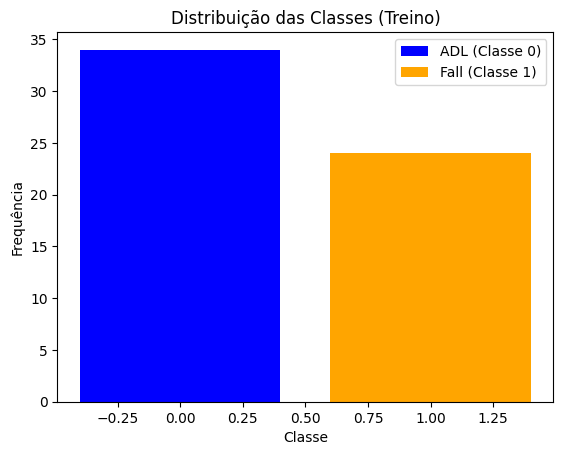

In [12]:
import matplotlib.pyplot as plt

class_distribution = train_df['class'].value_counts()
colors = ['blue', 'orange']

bar1 = plt.bar(class_distribution.index[0], class_distribution.values[0], color=colors[0], label='ADL (Classe 0)')
bar2 = plt.bar(class_distribution.index[1], class_distribution.values[1], color=colors[1], label='Fall (Classe 1)')

plt.title('Distribuição das Classes (Treino)')
plt.xlabel('Classe')
plt.ylabel('Frequência')

plt.legend()

plt.show()

Também são mostrados os gráficos com as distribuições de cada classe criada anteriormente, a fim de observar como essas classes se distribuem no conjunto de teste.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(train_df):
    features = ['mean', 'max', 'std', 'amplitude', 'energy']
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 1)
        sns.histplot(train_df[train_df['class'] == 1][feature], color='r', label='Queda', kde=True)
        sns.histplot(train_df[train_df['class'] == 0][feature], color='b', label='ADL', kde=True)
        plt.title(feature.capitalize())
        plt.xlabel(feature.capitalize())
        plt.ylabel('Frequência')
        plt.legend()
    plt.tight_layout()
    plt.show()

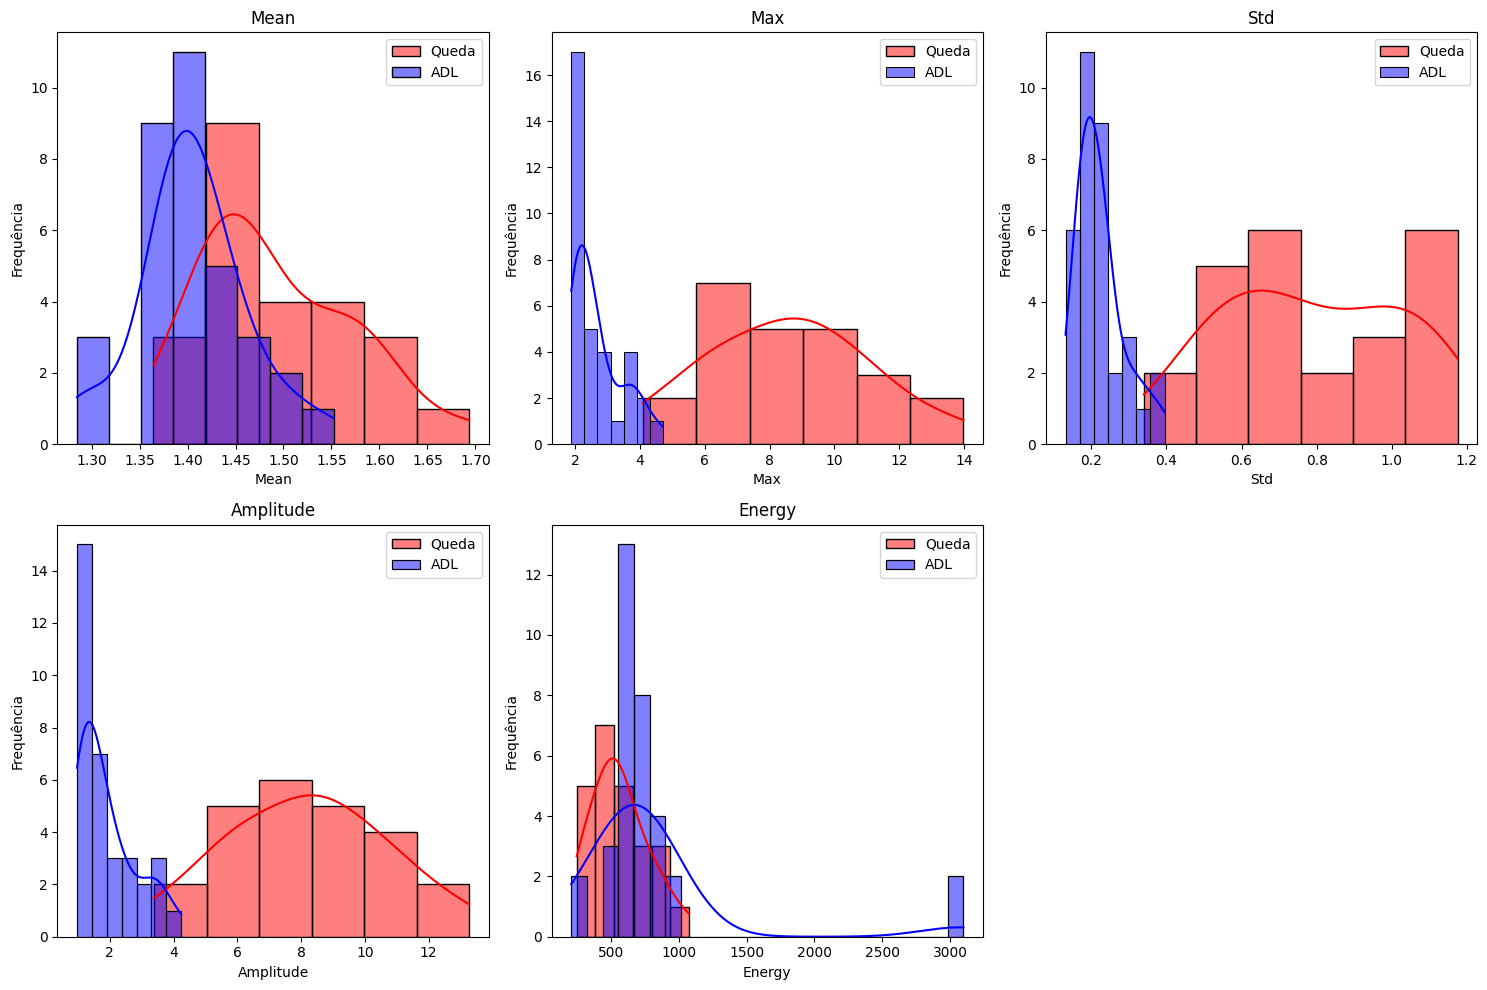

In [14]:
plot_feature_distributions(train_df)

---

Utilização dos classificadores

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

X_train = train_df.drop(columns=['class'])
y_train = train_df['class']
X_test = test_df.drop(columns=['class'])
y_test = test_df['class']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

models = {
    'Perceptron': Perceptron(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'kNN': KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred)

    results[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Classification Report': train_report,
        'Test Classification Report': test_report
    }

for name, result in results.items():
    print(f"Model: {name}")
    print(f"Train Accuracy: {result['Train Accuracy']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("Train Classification Report:")
    print(result['Train Classification Report'])
    print("Test Classification Report:")
    print(result['Test Classification Report'])
    print("-" * 60)

Model: Perceptron
Train Accuracy: 0.9828
Test Accuracy: 1.0000
Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        34
         1.0       1.00      0.96      0.98        24

    accuracy                           0.98        58
   macro avg       0.99      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58

Test Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

------------------------------------------------------------
Model: Logistic Regression
Train Accuracy: 0.9828
Test Accuracy: 0.9167
Train Classification Report:
              precision    recall  f1-score   support

         